# Toy Model Implementation

In [1]:
import os

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import torch

import plotnine as p9

sclembas_path = 'LEMBAS'
import sys
sys.path.insert(1, os.path.join(sclembas_path))
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Input Data

In [3]:
# Prior knowledge signaling network
net = pd.read_csv('data/KEGGnet-Model.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
x_data = pd.read_csv(os.path.join('data', 'synthetic_data_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'synthetic_data_xcell.csv'), sep=',', low_memory=False, index_col=0)
x_drug = pd.read_csv(os.path.join('data', 'synthetic_data_xdrug.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'synthetic_data_y.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)

display(x_data.head())
display(x_cell.head())
display(x_drug.head())
display(y_data.tail(20))
display(nodes_sites_map.head())

,DMSO,D15,D35,D41,D47,D49,D65,D72
Drug_CL,,,,,,,,
DMSO_CL0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,CL0,CL1,CL3,CL4,CL5,CL6
Drug_CL,,,,,,
DMSO_CL0,1,0,0,0,0,0
DMSO_CL1,0,1,0,0,0,0
DMSO_CL3,0,0,1,0,0,0
DMSO_CL4,0,0,0,1,0,0
DMSO_CL5,0,0,0,0,1,0


,DMSO,D15,D35,D41,D47,D49,D65,D72
O14511,0,0,0,0,0,0,0,0
O14788,0,0,0,0,0,0,0,0
O14944,0,0,0,0,0,0,0,0
O43557,0,0,0,0,1,0,0,0
O75093,0,0,0,0,0,0,0,0


,O00206_site_1,O00206_site_2,O00206_site_3,O00206_site_4,O00206_site_5,O14492_site_1,O14492_site_2,O14511_site_1,O14511_site_2,O14511_site_3,...,Q9Y4D1_site_5,Q9Y4D1_site_6,Q9Y4D1_site_7,Q9Y4D1_site_8,Q9Y4D1_site_9,Q9Y6K9_site_1,Q9Y6K9_site_2,Q9Y6K9_site_3,Q9Y6N7_site_1,Q9Y6Q6_site_1
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D47_CL5_50,NaN,0.506037,0.284719,0.343082,NaN,0.025183,0.000576,0.00281,0.015187,NaN,...,0.061399,0.040849,NaN,0.028475,0.052814,NaN,NaN,-0.007892,NaN,0.040838
D47_CL6_50,-0.000051,-0.000064,-0.000036,-0.000044,NaN,NaN,0.000576,0.00281,0.015187,NaN,...,NaN,0.040849,0.007392,0.028475,NaN,-0.002507,-0.006059,NaN,-0.000194,0.040838
D49_CL0_50,-0.000013,-0.000017,-0.000009,-0.000011,0.000003,NaN,0.000576,NaN,0.015187,NaN,...,NaN,0.040849,NaN,NaN,0.052814,-0.002786,-0.006734,-0.002803,NaN,0.011612
D49_CL1_50,-0.000013,-0.000017,-0.000009,-0.000011,NaN,0.025177,0.000576,NaN,0.015187,NaN,...,NaN,0.040849,0.007392,NaN,0.052814,NaN,-0.006156,-0.002562,NaN,-0.001382
D49_CL3_50,-0.000013,NaN,-0.000009,-0.000011,NaN,NaN,0.000425,NaN,0.015187,0.010226,...,NaN,0.040849,0.007392,NaN,NaN,-0.003197,-0.007727,NaN,NaN,0.031096
D49_CL4_50,-0.000051,-0.000064,-0.000036,-0.000044,NaN,NaN,0.000576,NaN,0.015187,0.010226,...,NaN,NaN,NaN,NaN,0.052814,NaN,-0.007978,-0.003320,NaN,0.040838
D49_CL5_50,0.401326,0.506037,0.284719,0.343082,-0.088945,NaN,0.000576,NaN,0.015187,0.010226,...,NaN,0.040849,NaN,NaN,NaN,-0.007844,NaN,-0.007892,NaN,0.040838
D49_CL6_50,-0.000051,-0.000064,-0.000036,-0.000044,NaN,0.025183,0.000576,NaN,0.015187,NaN,...,NaN,0.040849,0.007392,NaN,0.052814,-0.002483,-0.006002,NaN,NaN,0.040838
D65_CL0_50,NaN,-0.000017,-0.000009,-0.000011,0.000003,0.025183,0.000576,0.00281,0.015187,NaN,...,NaN,0.040849,NaN,NaN,NaN,NaN,-0.006823,NaN,NaN,0.011612


,O00206,O14492,O14511,O14640,O14727,O14733,O14788,O14920,O14944,O15111,...,Q9UJU2,Q9ULW2,Q9UMX1,Q9UPT6,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Phosphosite,,,,,,,,,,,,,,,,,,,,,
O00206_site_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O00206_site_2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O00206_site_3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O00206_site_4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
O00206_site_5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
display(net.head())
#display(condition_input.head())
#display(ligand_input.head())
#display(data_out.head())
#display(tf_output.head())

,source,target,direction,stimulation,inhibition,sources,references
0,O15111,P19838,1,1,0,CancerCellMap;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIM...,CancerCellMap:10469655;CancerCellMap:12482991;...
1,P45985,P45983,1,1,0,ACSN;ELM;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;Inn...,ACSN:11274345;ACSN:12624093;ACSN:12738796;ACSN...
2,Q13009,P63000,1,1,0,ACSN;Adhesome;BioGRID;CA1;HPRD;KEGG;Lit-BM-17;...,ACSN:11955434;ACSN:12829230;ACSN:15611338;ACSN...
3,P01112,Q13009,1,1,0,ACSN;Adhesome;HPRD;InnateDB;KEGG;SPIKE;Wang,ACSN:12134164;ACSN:7673236;ACSN:9069260;Adheso...
4,Q92851,P55957,1,1,0,HPRD;KEGG;SPIKE,HPRD:15772077;SPIKE:16186808


Let's see what the signaling network looks like:

In [5]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
0,O15111,P19838,1,0
1,P45985,P45983,1,0
2,Q13009,P63000,1,0
3,P01112,Q13009,1,0
4,Q92851,P55957,1,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [6]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
0,O15111,P19838,1.0,1,0
1,P45985,P45983,1.0,1,0
2,Q13009,P63000,1.0,1,0
3,P01112,Q13009,1.0,1,0
4,Q92851,P55957,1.0,1,0


## Define Parameters to Build and Train Model

In [7]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 1000, 
             'learning_rate': 2e-3}
other_params = {'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params}  # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

module_params = {
    'use_cln': True,
    'cln_hidden_layers': {1: 64, 2: 16},  # {1: 64, 2: 32}
    'use_xssn': True,
    'xssn_hidden_layers': {1: 64, 2: 16},
    'nsl_hidden_layers': None,
    'n_timepoints': 8,
    'time_init': None
}

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [8]:
mod = SignalingModel(net = net,
                     X_in = x_data,
                     y_out = y_data, 
                     X_cell = x_cell,
                     X_drug = x_drug,
                     nodes_sites_map = nodes_sites_map,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     dtype = torch.float32, device = device, seed = seed, module_params = module_params)

#X_in = mod.df_to_tensor(mod.X_in)
#y_out = mod.df_to_tensor(mod.y_out)

In [9]:
mod.X_in.head()

,DMSO,D15,D35,D41,D47,D49,D65,D72
Drug_CL,,,,,,,,
DMSO_CL0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DMSO_CL5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
mod.y_out.head()

Phosphosite,O00206_site_1,O00206_site_2,O00206_site_3,O00206_site_4,O00206_site_5,O14492_site_1,O14492_site_2,O14511_site_1,O14511_site_2,O14511_site_3,...,Q9Y4D1_site_5,Q9Y4D1_site_6,Q9Y4D1_site_7,Q9Y4D1_site_8,Q9Y4D1_site_9,Q9Y6K9_site_1,Q9Y6K9_site_2,Q9Y6K9_site_3,Q9Y6N7_site_1,Q9Y6Q6_site_1
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_CL0_0,-0.000013,NaN,-0.000009,-0.000011,NaN,0.025183,NaN,0.00281,0.015187,0.010226,...,NaN,0.040849,0.007392,NaN,0.052814,NaN,-0.006902,-0.002872,-0.000193,0.011612
DMSO_CL1_0,-0.000013,-0.000017,-0.000009,-0.000011,0.000003,0.025177,NaN,NaN,0.015187,NaN,...,0.061399,NaN,0.007392,0.028475,0.052814,NaN,-0.006292,NaN,NaN,-0.001382
DMSO_CL3_0,-0.000013,-0.000017,-0.000009,-0.000011,NaN,NaN,0.000425,NaN,0.015187,0.010226,...,NaN,0.040849,0.007392,NaN,NaN,NaN,NaN,NaN,-0.000193,0.031096
DMSO_CL4_0,-0.000051,-0.000064,-0.000036,-0.000044,0.000011,NaN,0.000576,NaN,0.015187,NaN,...,NaN,0.040849,0.007392,NaN,0.052814,-0.003347,-0.008090,-0.003367,NaN,0.040838
DMSO_CL5_0,0.401326,NaN,0.284719,0.343082,NaN,0.025183,0.000576,NaN,0.015187,NaN,...,0.061399,0.040849,0.007392,NaN,0.052814,-0.007844,-0.018963,-0.007892,NaN,0.040838


A forward pass looks like this:

In [11]:
# X_in = mod.df_to_tensor(mod.X_in) # ligand inputs
# X_full = mod.input_layer(X_in) # ligand inputs in signaling network
# Y_full = mod.signaling_network(X_full) # signaling network weights
# Y_hat = mod.output_layer(Y_full) # TF outputs of signaling network

## Train Model

In [ ]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_train_index, y_train, y_test, y_train_index, X_cell_train, X_cell_test, missing_node_indexes, floor_idx, ceil_idx, weight = train_signaling_model(
    mod, net, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_split_frac = {'train': 0.7, 'test': 0.3, 'validation': None}, train_seed = seed, 
    verbose = True, split_by = 'condition', noise_scale = 0.001) 

# store results
io.write_pickled_object(stats, os.path.join('data', 'training_stats_cond.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join('data', 'mac_state_dict_cond.pth'))

i=0, l=0.07224, s=0.425, r=0.00020, v=0, Time-mapping index: [0, 15, 29, 41, 51, 60, 68, 74]
i=250, l=0.01347, s=0.539, r=0.00046, v=0, Time-mapping index: [0, 12, 25, 36, 46, 55, 63, 70]
i=500, l=0.00650, s=0.514, r=0.00110, v=0, Time-mapping index: [0, 1, 4, 10, 16, 22, 29, 35]


## Predict Using Model

In [ ]:
mod.load_state_dict(torch.load(os.path.join('data', 'mac_state_dict_cond.pth'), map_location=torch.device('cpu')))
stats = io.read_pickled_object(os.path.join('data', 'training_stats_cond.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_27588\560733483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
X_in = mod.df_to_tensor(mod.X_in)
X_cell = mod.df_to_tensor(mod.X_cell)
mod.eval()
Y_hat, Y_full, Y_fullFull = mod(X_in, X_cell, missing_node_indexes)  # to know which nodes are missing and should be excluded from the node-site mapping

torch.Size([1035])


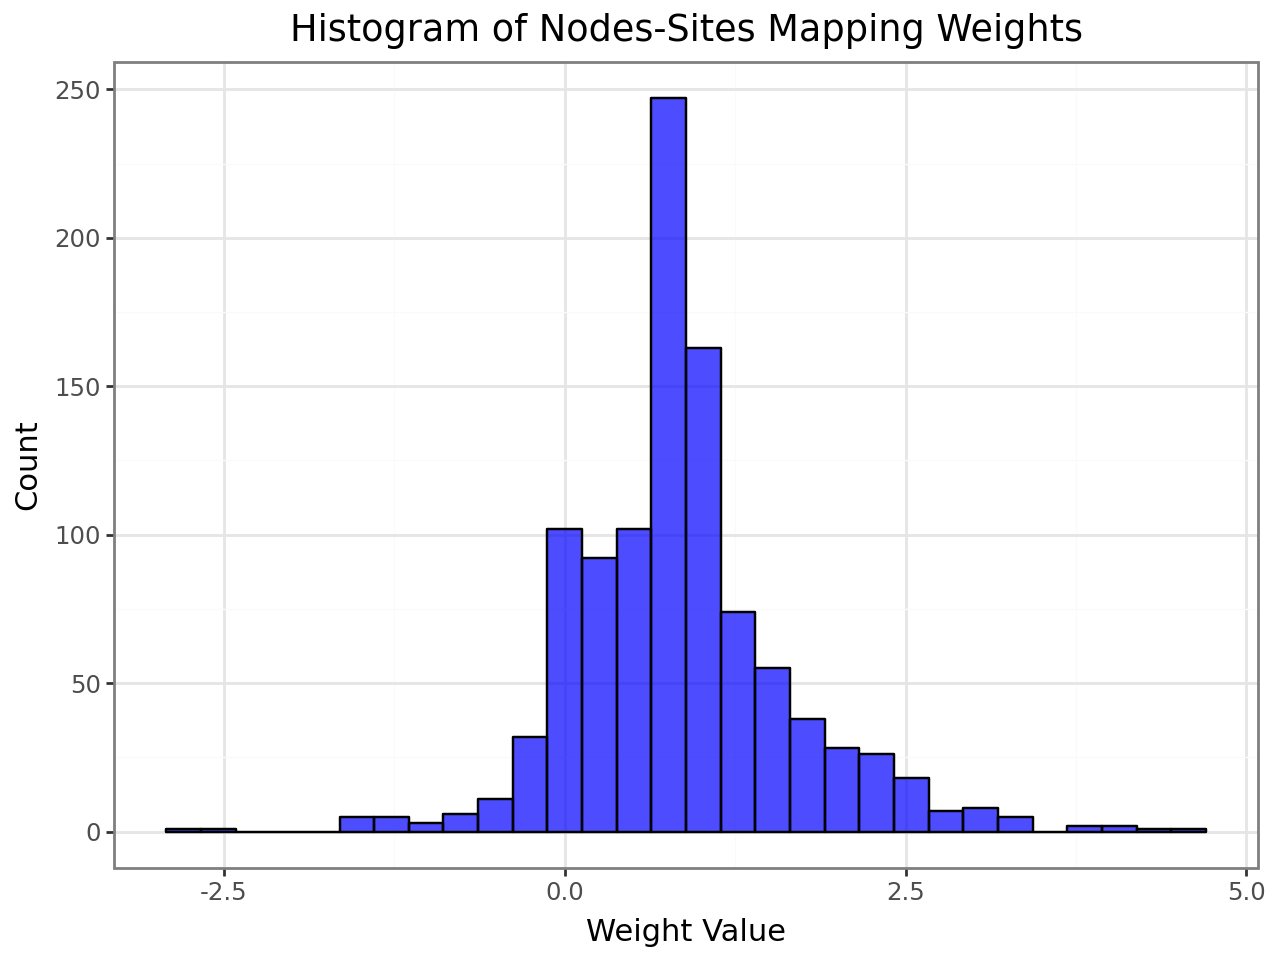

In [ ]:
nodes_sites_weights = mod.nodes_sites_layer.real_weights
print(nodes_sites_weights.shape)
weights_np = nodes_sites_weights.detach().cpu().numpy().flatten()
df_weights = pd.DataFrame({'Weight': weights_np})

p_hist = (
    p9.ggplot(df_weights, p9.aes(x='Weight')) +
    p9.geom_histogram(bins=30, fill="blue", color="black", alpha=0.7) +
    p9.labs(x="Weight Value", y="Count", title="Histogram of Nodes-Sites Mapping Weights") +
    p9.theme_bw()
)
p_hist.show()

## Visualize

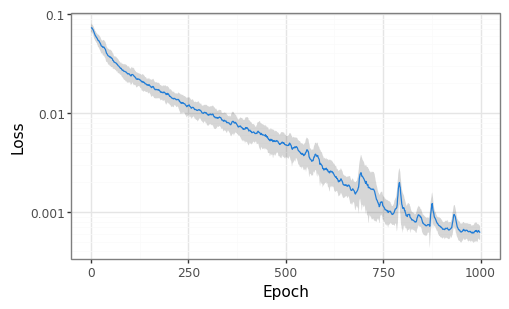

In [ ]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
p1A.draw()

As well as how the learning rate was adjusted across training:

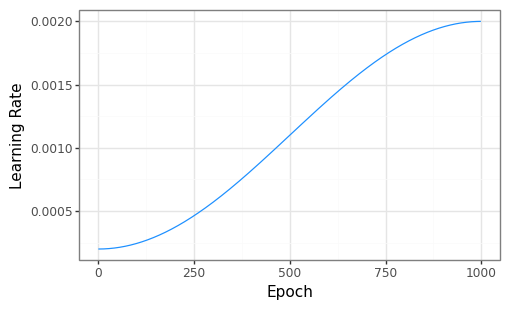

In [ ]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

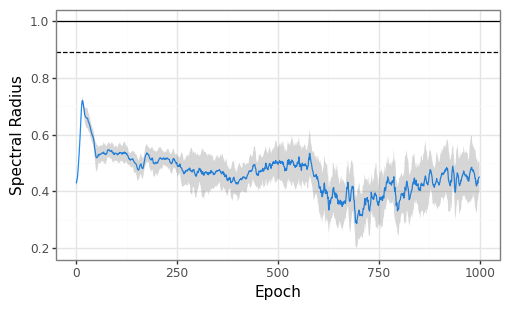

In [ ]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Plot how the time mapping is changing across epochs

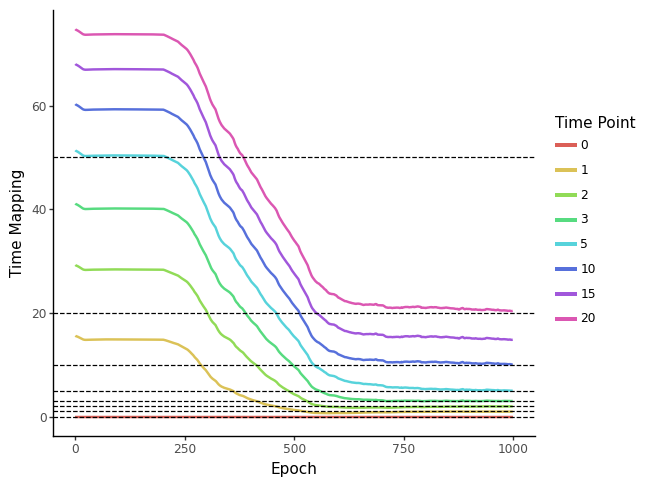

In [ ]:
# Prepare the data for plotting
epochs = np.array(range(len(stats['mapping'])))
mapping_data = []

last_iteration_mapping = np.round(stats['mapping'][-1]).astype(int).tolist()  # Last values of mapping

for epoch, mapping in enumerate(stats['mapping']):
    for time_point, value in enumerate(mapping):
        time_point_name = last_iteration_mapping[time_point]
        mapping_data.append({'Epoch': epoch, 'Time Point': str(time_point_name), 'Value': value})

mapping_df = pd.DataFrame(mapping_data)
mapping_df['Time Point'] = pd.Categorical(mapping_df['Time Point'], categories=[str(tp) for tp in last_iteration_mapping], ordered=True)

# Real time points
real_time_points = [0, 1, 2, 3, 5, 10, 20, 50]
real_time_df = pd.DataFrame({'Real Time Points': real_time_points})

# Generate a color palette dictionary
color_palette = dict(zip(mapping_df['Time Point'].cat.categories, p9.scale_color_hue().palette(len(mapping_df['Time Point'].cat.categories))))

# Plot using plotnine
p = (
    p9.ggplot(mapping_df, p9.aes(x='Epoch', y='Value', color='Time Point')) +
    p9.geom_line(size=1) +
    p9.geom_hline(p9.aes(yintercept='Real Time Points'), data=real_time_df, color='black', linetype='dashed') +
    p9.scale_color_manual(values=color_palette) +
    p9.labs(x='Epoch', y='Time Mapping', color='Time Point') +
    p9.theme_classic()
)

p.draw()

### Model Benchmarking

Evaluate model. Plot correlation for each site after subtracting the time point zero from the site trajectory for each drug-cell line combination. Plot correlations across sites and across samples. Plot example site trajectory across cell lines and drugs.

torch.Size([344, 1035]) torch.Size([344, 1035])


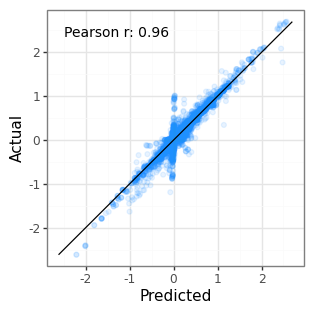

In [ ]:
def subsample_Y(Y, floor_idx, ceil_idx, weight):
    """
    Subsample Y using the provided indices and weights.

    Parameters
    ----------
    Y : torch.Tensor
        The tensor to be subsampled.
    floor_idx : torch.Tensor
        The floor indices for subsampling.
    ceil_idx : torch.Tensor
        The ceil indices for subsampling.
    weight : torch.Tensor
        The interpolation weights.

    Returns
    -------
    Y_subsampled : torch.Tensor
        The subsampled tensor.
    """
    Y = Y.to('cpu')
    
    # Reduce dimensions of indices
    floor_idx_reduced = floor_idx[0, :, 0]
    ceil_idx_reduced = ceil_idx[0, :, 0]
    
    # Gather the corresponding hidden state outputs
    Y_floor = Y[:, floor_idx_reduced, :]  # (batch, K, feat)
    Y_ceil = Y[:, ceil_idx_reduced, :]  # (batch, K, feat)
    
    # Perform linear interpolation
    Y_subsampled = (1 - weight) * Y_floor + weight * Y_ceil
    
    return Y_subsampled


y_index = mod.y_out.index.tolist()
y_actual = y_train

#time_points = [int(idx.rsplit('_', 1)[-1]) for idx in y_index]
#seen = set()
#unique_time_points = [x for x in time_points if not (x in seen or seen.add(x))]
#Y_subsampled = Y_fullFull[:, unique_time_points, :]
Y_hat_train, Y_full_train, Y_fullFull_train = mod(X_train, X_cell_train, missing_node_indexes)

Y_subsampled = subsample_Y(Y_fullFull_train, floor_idx, ceil_idx, weight)
Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(8, len(X_train_index), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

torch.Size([40, 1035]) torch.Size([40, 1035])


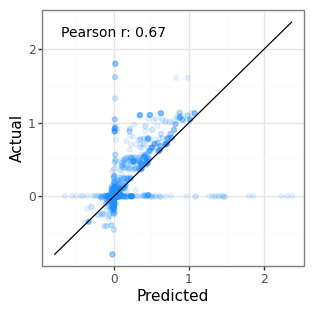

In [ ]:
y_index = mod.y_out.index.tolist()
y_actual = y_test

Y_hat_test, Y_full_test, Y_fullFull_test = mod(X_test, X_cell_test, missing_node_indexes)

Y_subsampled = subsample_Y(Y_fullFull_test, floor_idx, ceil_idx, weight)
Y_subsampled = Y_subsampled - Y_subsampled[:, 0:1, :]  # Subtract the first time point from the predicted data
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)

y_actual = y_actual.reshape(8, 48-len(X_train_index), mod.y_out.shape[1])
y_actual = y_actual - y_actual[0:1, :, :]  # Subtract the first time point from the actual data
y_actual = torch.flatten(y_actual, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_actual.shape)

y_pred_np = Y_subsampled.detach().flatten().cpu().numpy()
y_actual_np = y_actual.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred_np) & ~np.isnan(y_actual_np)
y_pred_filtered = y_pred_np[mask]
y_actual_filtered = y_actual_np[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
min_val = min(viz_df['Predicted'].min(), viz_df['Actual'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text', 
        x=min_val + 0.25*(max_val-min_val), 
        y=max_val - 0.05*(max_val-min_val), 
        label='Pearson r: {:.2f}'.format(pr), 
        size=10
    )
)
p2.draw()

C:\Users\kanto\AppData\Local\Temp\ipykernel_27588\1133771981.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 1684 rows containing non-finite values.
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 1684 rows containing missing values.


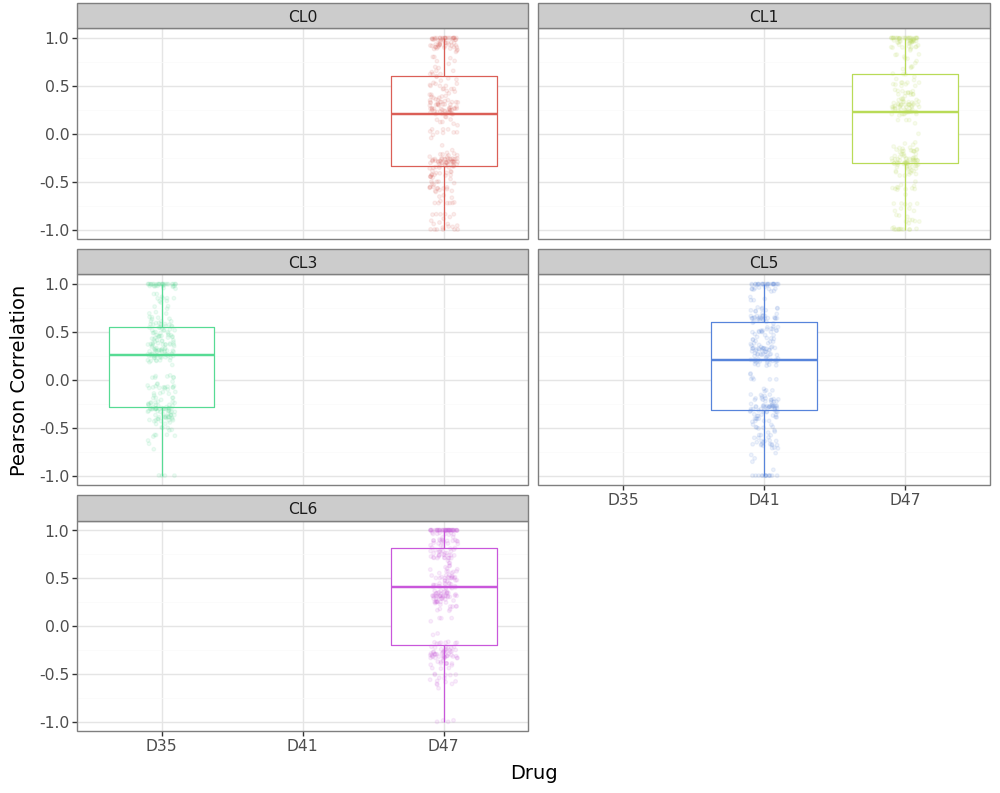

In [ ]:
filtered_y_index = [idx for idx in mod.y_out.index.tolist() if idx not in y_train_index]
site_names = mod.y_out.columns.tolist()

meta = []
for i, index_str in enumerate(filtered_y_index):
    parts = index_str.split('_')
    
    drug, cell_line, time = parts[0], parts[1], float(parts[2])
    meta.append({'row': i, 'drug': drug, 'cell_line': cell_line, 'time': time})
meta_df = pd.DataFrame(meta)

y_pred_np = Y_subsampled.detach().cpu().numpy()
y_actual_np = y_actual.detach().cpu().numpy()

corr_list = []
for (drug, cell_line), group in meta_df.groupby(['drug', 'cell_line']):
    group = group.sort_values('time')
    rows = group['row'].tolist()  # indices corresponding to this condition's time points
    for site in range(y_pred_np.shape[1]):  # for each site (gene)
        ts_pred = y_pred_np[rows, site]
        ts_actual = y_actual_np[rows, site]
        # Mask NaNs
        mask = ~np.isnan(ts_pred) & ~np.isnan(ts_actual)
        ts_pred = ts_pred[mask]
        ts_actual = ts_actual[mask]
        
        if len(ts_pred) > 1:
            r, _ = pearsonr(ts_pred, ts_actual)
            corr_list.append({'drug': drug, 'cell_line': cell_line, 'site': site_names[site], 'correlation': r})
corr_df = pd.DataFrame(corr_list)

p_corr = (p9.ggplot(corr_df, p9.aes(x='drug', y='correlation', color='cell_line'))
           + p9.geom_boxplot()
           + p9.geom_jitter(position=p9.position_jitter(width=0.1, height=0), size=1, alpha=0.1)
           + p9.facet_wrap("~ cell_line", ncol=2)
           + p9.scale_y_continuous(limits=(-1, 1))
           + p9.labs(x="Drug", y="Pearson Correlation")
           + p9.theme_bw(base_size=14)
           + p9.theme(figure_size=(10,8), legend_position='none'))
p_corr.draw()

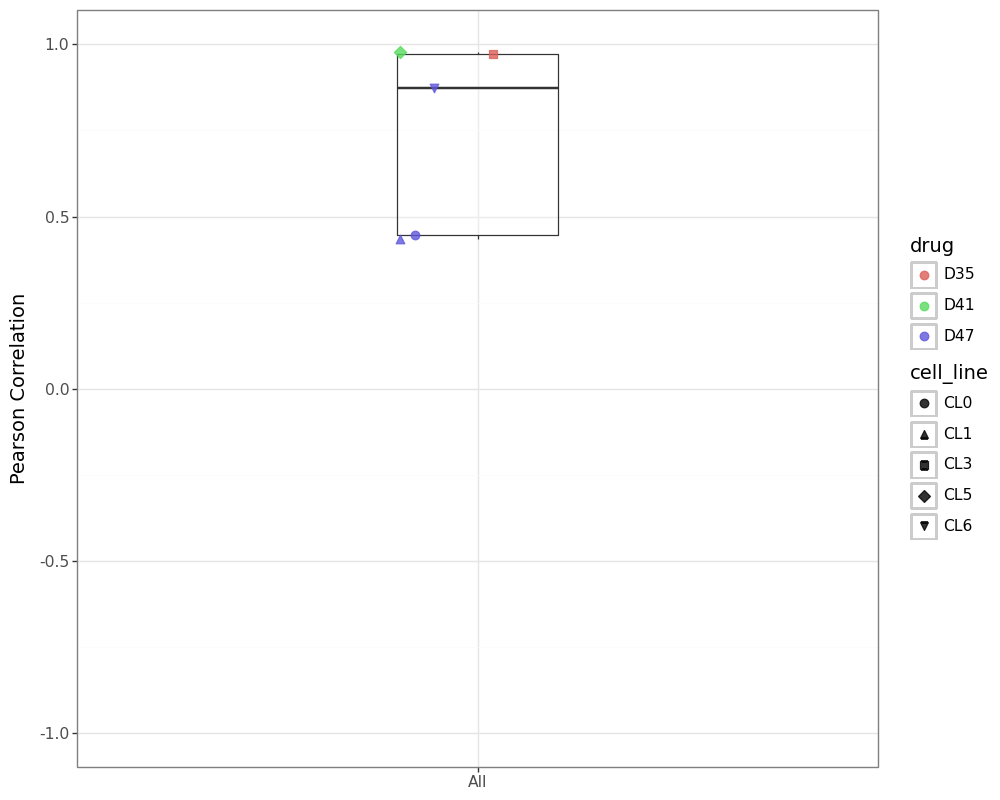

In [ ]:
meta_df['sample'] = meta_df['drug'] + "_" + meta_df['cell_line']

# Compute the correlation for each sample (drug–cell_line combination)
corr_list = []
for sample, group in meta_df.groupby('sample'):
    # Get constant sample properties
    drug = group['drug'].iloc[0]
    cell_line = group['cell_line'].iloc[0]
    
    # Get the rows corresponding to all time points for this sample.
    rows = group['row'].tolist()
    sample_ts_pred = y_pred_np[rows, :]    # shape: (n_time_points, n_sites)
    sample_ts_actual = y_actual_np[rows, :]
    ts_pred_flat = sample_ts_pred.flatten()
    ts_actual_flat = sample_ts_actual.flatten()
    
    # Remove NaN
    mask = (~np.isnan(ts_pred_flat)) & (~np.isnan(ts_actual_flat))
    ts_pred_valid = ts_pred_flat[mask]
    ts_actual_valid = ts_actual_flat[mask]
    
    if len(ts_pred_valid) > 1:
        r, _ = pearsonr(ts_pred_valid, ts_actual_valid)
        corr_list.append({
            'sample': sample,
            'drug': drug,
            'cell_line': cell_line,
            'correlation': r
        })

corr_df = pd.DataFrame(corr_list)
corr_df['x'] = 'All'

plot_corr = (
    p9.ggplot(corr_df, p9.aes(x='"All"', y='correlation'))
    + p9.geom_boxplot(alpha=0.3, width=0.2, outlier_alpha=0)
    + p9.geom_jitter(
          mapping=p9.aes(color='drug', shape='cell_line'),
          position=p9.position_jitter(width=0.1, height=0),
          size=3, alpha=0.8
      )
    + p9.scale_y_continuous(limits=(-1, 1))
    + p9.labs(x="", y="Pearson Correlation")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(10,8), legend_position='right')
)
plot_corr.draw()

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 33 rows containing missing values.


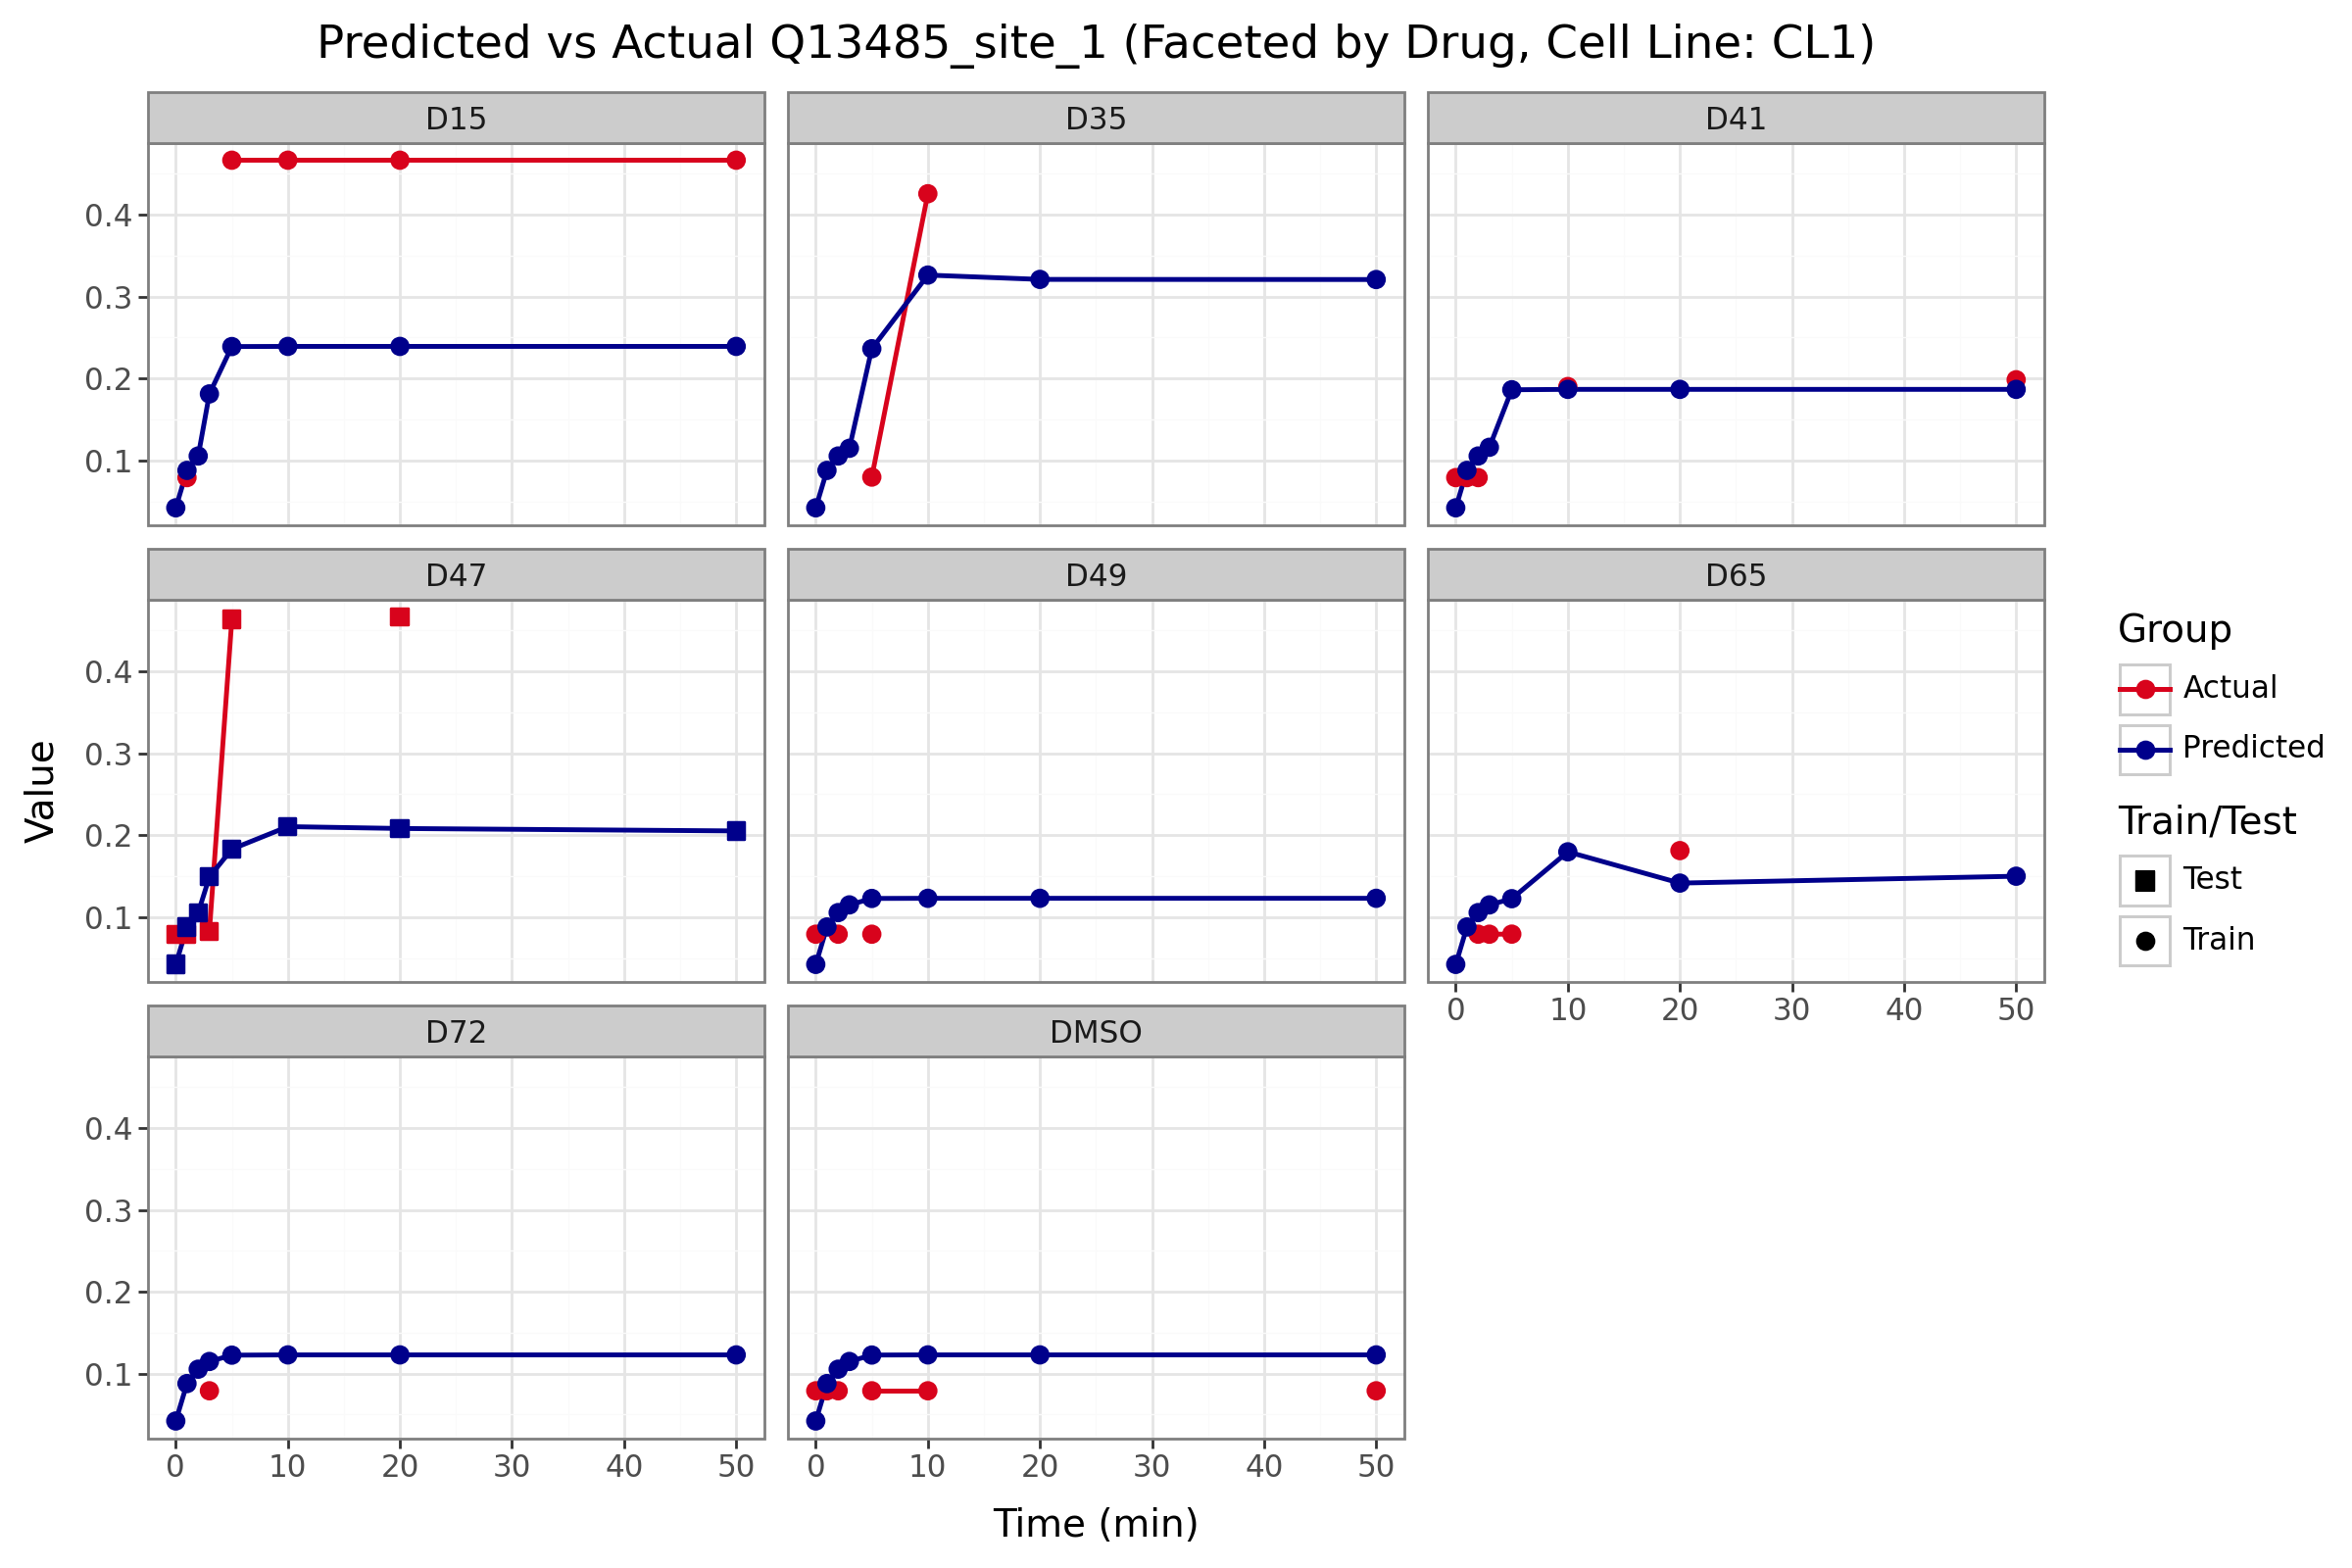

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 32 rows containing missing values.


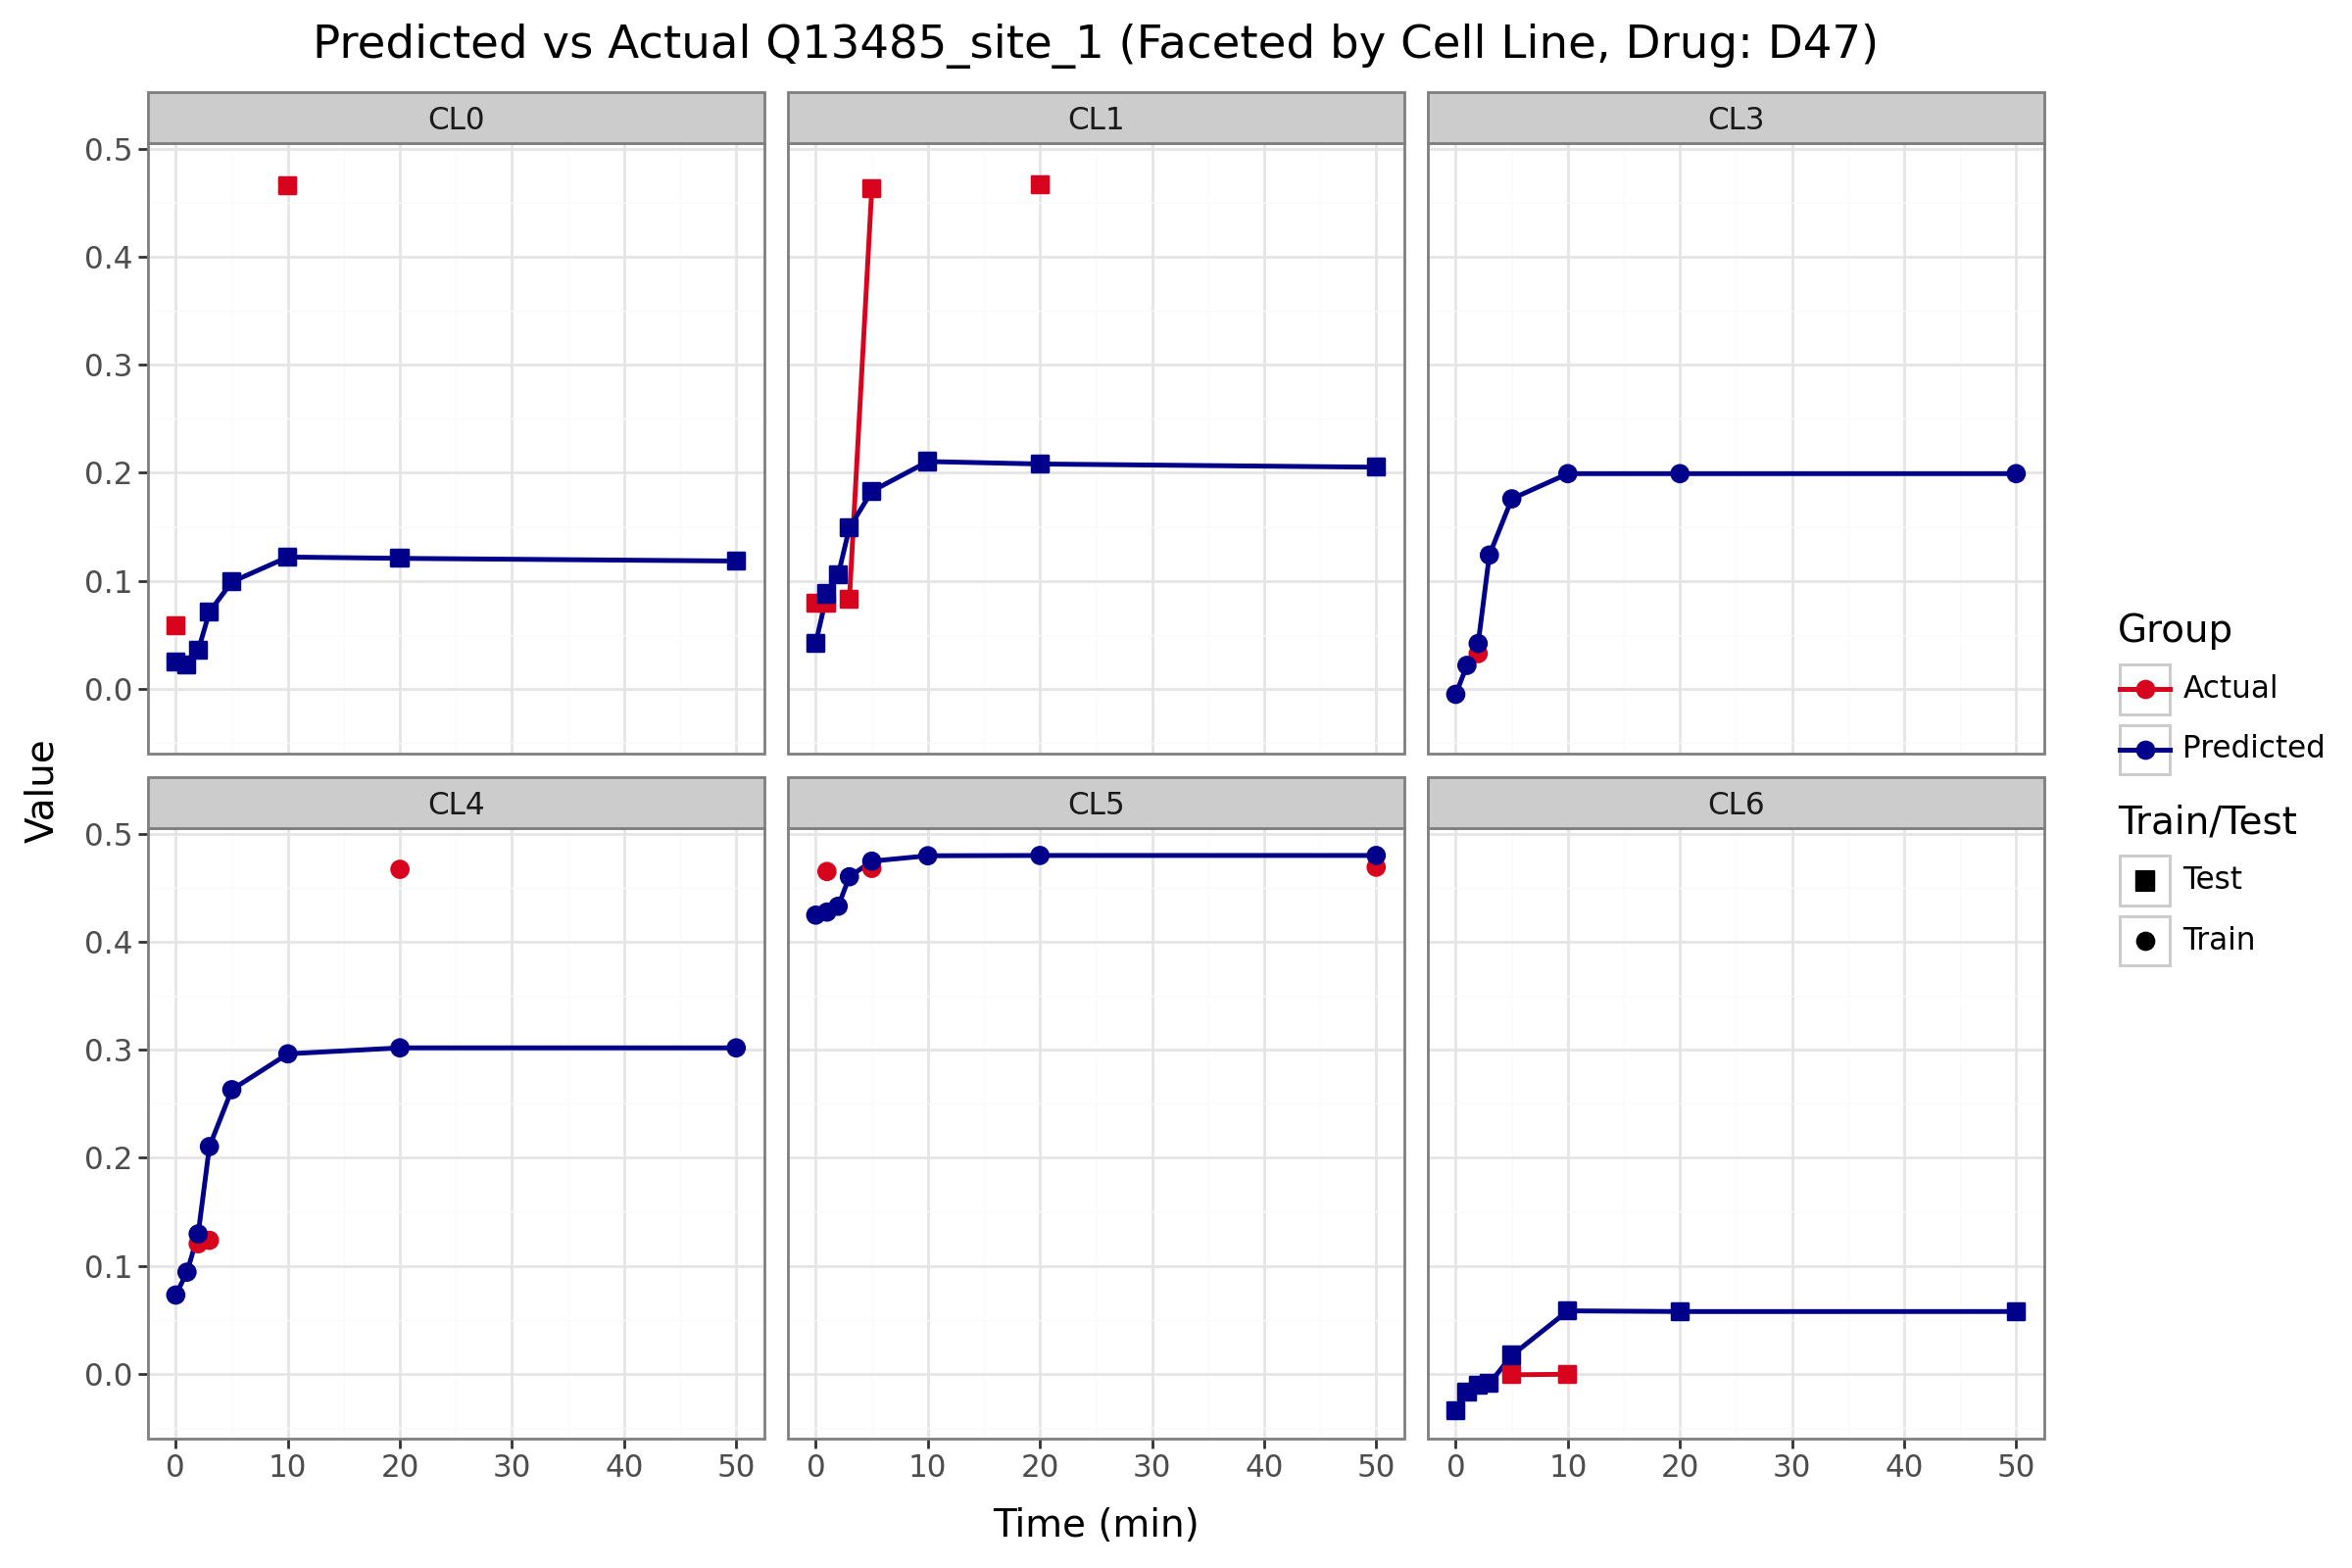

In [ ]:
drug_input = "D47"
cl_input = "CL1"
phosphosite_input = "Q13485_site_1"
x_values = [0, 1, 2, 3, 5, 10, 20, 50]  #list(range(150))  [0, 2 , 5, 12, 28, 64, 149]  [0, 3, 6, 9, 12, 15, 18, 21]  [0, 1, 2, 3, 5, 10, 20, 50]
#Y_plot = Y_fullFull[:, x_values, :]
y_out = mod.df_to_tensor(mod.y_out)
Y_plot = subsample_Y(Y_fullFull, floor_idx, ceil_idx, weight)
Y_plot = Y_plot.permute(1, 0, 2)
Y_plot = torch.flatten(Y_plot, start_dim=0, end_dim=1)

# Prepare the Y_actual
y_actual = y_data.reset_index().rename(columns={"index": "Drug_CL_Time"})

y_actual[['Drug', 'CL', 'Time']] = y_actual['Drug_CL_Time'].str.split('_', expand=True)
y_actual['Time'] = y_actual['Time'].astype(int)

df_cell = y_actual[y_actual['CL'] == cl_input].copy()
df_drug = y_actual[y_actual['Drug'] == drug_input].copy()

df_cell['Group'] = df_cell['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug['Group'] = df_drug['Drug_CL_Time'].isin(y_train_index).map({True: "Train", False: "Test"})

# Sort the DataFrames by time for clarity.
df_cell = df_cell.sort_values(by=['Drug', 'CL', 'Time'])
df_drug = df_drug.sort_values(by=['Drug', 'CL', 'Time'])

cell_conditions = df_cell['Drug_CL_Time'].tolist()
drug_conditions = df_drug['Drug_CL_Time'].tolist()

cell_indices = [y_data.index.get_loc(cond) for cond in cell_conditions]
drug_indices = [y_data.index.get_loc(cond) for cond in drug_conditions]

phosphosite_idx = y_data.columns.get_loc(phosphosite_input)

# For the cell subset:
Y_cell_site = Y_plot[cell_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in cell_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_cell_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_cell_site.detach().cpu().numpy(),
    'Drug': Drug
})

# For the drug subset:
Y_drug_site = Y_plot[drug_indices, phosphosite_idx]

Drug, CL, Time = zip(*[cond.split('_') for cond in drug_conditions])
Time = list(map(int, Time))  
Drug = list(Drug)
df_drug_pred = pd.DataFrame({
    'X': Time,
    'Y': Y_drug_site.detach().cpu().numpy(),
    'CL': CL
})

# Create the actual data
df_cell = df_cell[df_cell['Drug_CL_Time'].isin(cell_conditions)]
df_cell["Train/Test"] = df_cell["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_cell = df_cell[['Time', phosphosite_input, 'Drug', "Train/Test"]]
df_cell = df_cell.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_cell["Group"] = "Actual"

df_drug = df_drug[df_drug['Drug_CL_Time'].isin(drug_conditions)]
df_drug["Train/Test"] = df_drug["Drug_CL_Time"].isin(y_train_index).map({True: "Train", False: "Test"})
df_drug = df_drug[['Time', phosphosite_input, 'CL', "Train/Test"]]
df_drug = df_drug.rename(columns={"Time": "X", phosphosite_input: "Y"})
df_drug["Group"] = "Actual"

df_cell_pred['Train/Test'] = df_cell['Train/Test'].reset_index(drop=True)
df_cell_pred['Group'] = "Predicted"
df_drug_pred['Train/Test'] = df_drug['Train/Test'].reset_index(drop=True)
df_drug_pred['Group'] = "Predicted"

df_cell_plot = pd.concat([df_cell, df_cell_pred], axis=0)
df_drug_plot = pd.concat([df_drug, df_drug_pred], axis=0)

# Plot A: Facet by Drug (for the specified cell line)
plot_A = (
    p9.ggplot(df_cell_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ Drug')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 's'})
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Drug, Cell Line: {cl_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_A.show()

# Plot B: Facet by Cell Line (for the specified drug)
plot_B = (
    p9.ggplot(df_drug_plot, p9.aes(x='X', y='Y', color='Group', shape='Train/Test'))
    + p9.geom_line(size=1)
    + p9.geom_point(size=3)
    + p9.facet_wrap('~ CL')
    + p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'})
    + p9.scale_shape_manual(values={'Train': 'o', 'Test': 's'})
    + p9.labs(title=f"Predicted vs Actual {phosphosite_input} (Faceted by Cell Line, Drug: {drug_input})", x="Time (min)", y="Value")
    + p9.theme_bw(base_size=14)
    + p9.theme(figure_size=(12,8), legend_position='right')
)
plot_B.show()
